<a href="https://colab.research.google.com/github/duzan21/DeepLearningProjectMR/blob/develop/Noam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Hyperparams

loadTrainedModel =  True #@param {type:"boolean"}
action = "Show trained results" #@param ["Show trained results", "Analyze model history"]
networkType = "VGG"#@param ["CNN2","CNN2_FFT", "CNN2_ENSEMBLE", "VGG", "VGG_ENSEMBLE"]
dataSet = 'RML2016.10a_dict'#@param ["RML2016.10a_dict", "2016.04C.multisnr"]

learningRate = 0.00007 #@param {type:"slider", min:0.00001, max:0.0005, step:0.00001}
num_epochs = 1#@param {type:"slider", min:1, max:200, step:1}
epochStart = 0
dropout = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
batch_size =  1024#@param {type:"integer"}

rootDir = '/content/drive/My Drive/Deep Learning course 2020/Proj/'
SEED =  203142260 + 305773673

vggChannels = 1024
beta1 = 0.5
beta2 = 0.999




In [2]:
#@title imports and mount google drive

%matplotlib inline
import os,random,sys
import numpy as np
from collections import Counter
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
device = torch.device("cuda") 

import matplotlib.pyplot as plt
import time
from glob import glob
import re

# In Python 2, cPickle is the accelerated version of pickle, and a later addition to thestandard library.
# It was perfectly normal to import it with a fallback to pickle. In Python 3 the accelerated version has been integrated
# and there is simply no reason to use anything other than import pickle
import pickle

from google.colab import drive
drive.mount('/content/drive')
root = rootDir
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


# Dataset setup

In [3]:
#@title Dataset setup and FFT preprocess

def IQ2Complex(iqArray):
  return iqArray[:,0,:] + 1j*iqArray[:,1,:]
def Complex2IQ(complexArray):
  I = np.real(complexArray)
  Q = np.imag(complexArray)
  return np.concatenate((I[:,np.newaxis,:], Q[:,np.newaxis,:]), axis=1)


def load_dataset():
  global Xd, snrs, mods, X, lbl, XComplex, fftXComplex, fftX_IQ

  Xd = pickle.load(open(root + dataSet + ".pkl",'rb'), encoding="latin1")
  snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
  X = []  
  lbl = []
  for mod in mods:
      for snr in snrs:
          X.append(Xd[(mod,snr)])
          for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
  X = np.vstack(X)
  XComplex = IQ2Complex(X)
  fftXComplex = np.fft.fft(XComplex)
  fftX_IQ = np.array(Complex2IQ(fftXComplex), dtype=np.float32)

load_dataset()

'''
X: (N, 2, 128). for each of the N=220,000 examples, there is a 128-long measurement of I/Q samples.
mods: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
lbl: list of tuples, each of the pattern ('GFSK', -20)
'''

def plot_modulation_pdf():
  counterLbl = Counter(lbl)
  for snr in [snrs[0]]:
    lblSnr = {}
    for mod in mods:
      lblSnr[mod] = counterLbl[(mod, snr)]
    print(lblSnr)
    ticks = range(0, 10*len(lblSnr.values()), 10)
    plt.figure(figsize=(10, 3))  # width:10, height:8
    plt.bar(ticks,lblSnr.values(), align='center', width=1, )
    plt.xticks(ticks, lblSnr.keys())
    plt.show()

# plot_modulation_pdf()

In [4]:
#@title Dataset partition
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

def partition_dataset():
  global X, n_examples, n_train, train_idx, test_idx, X_train, X_FFT_test, X_test, X_FFT_test, Y_train, Y_test, test_SNRs, num_batches, epoch_size, isVGG, isEnsemble

  if networkType is "CNN2_FFT":
    X = np.concatenate((X, fftX_IQ), axis=1)
  # print(X.shape)
  # print(fftX_IQ.shape)
  # print(X.dtype)
  # print(fftX_IQ.dtype)
  # print(Counter(lbl))
  isVGG = False
  isEnsemble = False
  if networkType is not "CNN2_FFT":
    if "VGG" in networkType:
      isVGG = True
    if "ENSEMBLE" in networkType:
      isEnsemble = True

  np.random.seed(SEED)
  n_examples = X.shape[0]  # 220,000 C:162060
  n_train = int(n_examples * 0.6)  # 110,000 C:97236
  train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
  test_idx = list(set(range(0,n_examples))-set(train_idx))
  X_train = X[train_idx]
  X_FFT_train = fftX_IQ[train_idx]
  X_test =  X[test_idx]
  X_FFT_test = fftX_IQ[test_idx]

  Y_train = np.array(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
  Y_test = np.array(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

  test_SNRs = np.array(list(map(lambda x: lbl[x][1], test_idx)))


  
  # print(f'examples: {n_examples}, train={n_train}, test={len(X_test)}')
  # print(f'X_FFT_train.shape: {X_FFT_train.shape}')
  # print(f'X_train.shape: {X_train.shape}')
  # Set up some params 
  if isEnsemble:
    X_train = np.concatenate((X_train[:, np.newaxis, :, :], X_FFT_train[:, np.newaxis, :, :]), axis=1)
    X_test = np.concatenate((X_test[:, np.newaxis, :, :], X_FFT_test[:, np.newaxis, :, :]), axis=1)
  # print(X_train.shape)
  # print(X_test.shape)
  num_batches = len(X_train) // batch_size
  epoch_size = batch_size * num_batches

partition_dataset()

# Build the NN Model

In [5]:
#@title Setting up the network
#Pytorch
dr = dropout
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.convPart = nn.Sequential(
            # input is batch x 1 x 2 x 128
            # (Reshape([1]+in_shp, input_shape=in_shp))  #  - Reshape [N,2,128] to [N,1,2,128] on input
            nn.Conv2d(1, 256, kernel_size=(1, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256 x 2 x 130
            nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 80 x 1 x 132
        )
        
        self.firstLinearSize = 80 * 132
        self.linPart = nn.Sequential(
            nn.Linear(self.firstLinearSize, 256),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256
            nn.Linear(256, len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.convPart(input)
        out = out.view(-1, self.firstLinearSize)
        out = self.linPart(out)
        #out = F.softmax(out, dim=1)
        return out

class CNN2_FFT(nn.Module):
    def __init__(self):
        super(CNN2_FFT, self).__init__()
        self.convPart = nn.Sequential(
            # input is batch x 1 x 4 x 128
            # (Reshape([1]+in_shp, input_shape=in_shp))  #  - Reshape [N,2,128] to [N,1,2,128] on input
            nn.Conv2d(1, 256, kernel_size=(1, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256 x 2 x 130
            nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(3, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 80 x 2 x 132
        )
        
        self.firstLinearSize = 80 * 132 * 2
        self.linPart = nn.Sequential(
            nn.Linear(self.firstLinearSize, 256),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256
            nn.Linear(256, len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.convPart(input)
        out = out.view(-1, self.firstLinearSize)
        out = self.linPart(out)
        #out = F.softmax(out, dim=1)
        return out


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        channels = vggChannels
        self.convPart = nn.Sequential(
            # input is batch x 1 x 2 x 128
            # (Reshape([1]+in_shp, input_shape=in_shp))  #  - Reshape [N,2,128] to [N,1,2,128] on input
            nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=(2, 3), padding=(0, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((1,2),(1,2)),
            nn.Dropout(dr),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((1,2),(1,2)),
            nn.Dropout(dr),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((1,2),(1,2)),
            nn.Dropout(dr),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((1,2),(1,2)),
            nn.Dropout(dr)
            # state size. batch x channels x 1 x 8
            )
        
        self.firstLinearSize = channels * 8
        self.linPart = nn.Sequential(
            nn.Linear(self.firstLinearSize, 128),
            nn.ReLU(True),
            nn.Dropout(dr),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256
            nn.Linear(128, len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.convPart(input)
        out = out.view(-1, self.firstLinearSize)
        out = self.linPart(out)
        return out



class Ensemble(nn.Module):
    def __init__(self, isVGG = False):
        super(Ensemble, self).__init__()
        if isVGG == True:
          self.modelTimeSamples = VGG()
          self.modelFFTSamples = VGG()
        else:
          self.modelTimeSamples = CNN2()
          self.modelFFTSamples = CNN2()
        self.linPart = nn.Sequential(
            nn.Linear(2*len(mods), len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.modelTimeSamples(input[:,0])
        outFFT = self.modelFFTSamples(input[:,1]) 
        out = torch.cat((out, outFFT), 1)
        out = out.view(-1, 2*len(mods))
        out = self.linPart(out)
        #out = F.softmax(out, dim=1)
        return out

# custom weights initialization #  to mean=0, stdev=0.2.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def create_network():
  global net, criterion, optimizer

  net =  CNN2_FFT().to(device)
  if networkType is not "CNN2_FFT":
    if isVGG:
      net =  VGG().to(device)
    else:
      net =  CNN2().to(device)
    if isEnsemble:
      net =  Ensemble(isVGG).to(device)
  # Apply the weights_init function to randomly initialize all weights
  net.apply(weights_init)

  #criterion = nn.CrossEntropyLoss()
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(net.parameters(), lr=learningRate, betas=(beta1, beta2))

create_network()
print(net)

if isEnsemble:
  summary(net, (2, 1, 2, 128))
else:
  if networkType is "CNN2_FFT":
    summary(net, (1, 4, 128))
  else:
    summary(net, (1, 2, 128))



VGG(
  (convPart): Sequential(
    (0): Conv2d(1, 1024, kernel_size=(2, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(1024, 1024, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(1024, 1024, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(1024, 1024, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=False)
  )
  

# Model training

In [6]:
#@title Training helper functions
def prepare_data_into_batches(data, labels, permute, isEnsemble = False):
  # Prepare data
  if permute is True:
    perm = torch.randperm(len(data))  # Shuffles along the first axis. shape = (tot_size, 2, 128) just like X_train
  else:
    perm = np.arange(len(data))

  n_batches = len(data) // batch_size
  tot_size = n_batches * batch_size
  
  shuffled = data[perm]
  shuffled = shuffled[:tot_size]        # Cutting off the last part that is smaller than one batch.  shape = (tot_size, 2, 128) just like X_train
  if isEnsemble:
    prepared = shuffled.reshape(n_batches, -1, 2, 2, 128)  # Get into a shape that each element is a batch. 
    prepared = np.expand_dims(prepared, axis=3)           # Add a space for num_channels (it's 1 in our case).
  else:
    if networkType == "CNN2_FFT":
      prepared = shuffled.reshape(n_batches, -1, 4, 128)
    else:
      prepared = shuffled.reshape(n_batches, -1, 2, 128)  # Get into a shape that each element is a batch. 
    prepared = np.expand_dims(prepared, axis=2)           # Add a space for num_channels (it's 1 in our case). 

  labels = labels[perm]
  labels = labels[:tot_size]
  labels = labels.reshape(n_batches, -1)
  return prepared, labels
  
def get_batch_results(batch):
  batchData = torch.from_numpy(batch[0]).to(device)
  batchLabels = torch.from_numpy(batch[1]).to(device)
  
  output = net(batchData)
  _, pred = torch.max(output.detach(), dim=1)
  correct = torch.sum(pred.eq(batchLabels)).cpu().numpy()

  return output, batchLabels, correct

  
def save_network(epoch):
  path = f'{root}saved models/{networkType}/{networkType}_{dataSet}__epoch {epoch+1}.pth'
  torch.save(netD.state_dict(), path)

In [7]:
#@title Network training loop
def train_network():
  trainLoss = np.zeros(num_epochs)
  testLoss = np.zeros(num_epochs)

  startEpoch = 0
  #loadPath = f'{root}saved models/epoch {100}.pt'
  #filename = glob(loadPath)[0]
  #net.load_state_dict(torch.load(filename))

  for epoch in range(num_epochs):
    totEpoch = epoch + startEpoch
    print(f'epoch: {totEpoch + 1}/{num_epochs + startEpoch}, ', end='')
    start = time.time()

    trainData, trainLables = prepare_data_into_batches(X_train, Y_train, permute=True, isEnsemble=isEnsemble)
    testData, testLables = prepare_data_into_batches(X_test, Y_test, permute=True, isEnsemble=isEnsemble)
    
    net.train()
    correctTrain = 0
    trainEpochloss = 0
    for i, batch in enumerate(zip(trainData, trainLables)):
      net.zero_grad()

      output, batchLabels, correct = get_batch_results(batch)
      loss = criterion(output, batchLabels)
      loss.backward()
      optimizer.step()

      correctTrain += correct
      trainEpochloss += loss

    net.eval()
    correctTest = 0
    testEpochloss = 0
    with torch.no_grad():
      for i, batch in enumerate(zip(testData, testLables)):
        output, batchLabels, correct = get_batch_results(batch)
        correctTest += correct
        testEpochloss += criterion(output, batchLabels)

    trainAcc = correctTrain / epoch_size * 100
    testAcc = correctTest / epoch_size * 100
    trainLoss[epoch] = trainEpochloss / num_batches
    testLoss[epoch] = testEpochloss / num_batches
    print(f'train loss: {trainLoss[epoch]:.2f}, test loss: {testLoss[epoch]:.2f}, train accuracy: {trainAcc:.2f}%, test accuracy: {testAcc:.2f}%, elapsed time: {time.time() - start:.0f}s')
    
    # torch.save(net.state_dict(), f'{root}saved models/{networkType}/{networkType}_epoch{totEpoch+1}.pth')
    return trainLoss, testLoss

In [8]:
#@title Train network!


trainData, trainLables = prepare_data_into_batches(X_train, Y_train, permute=True, isEnsemble=isEnsemble)
# print(trainData.shape)
if loadTrainedModel is False:
  trainLoss, testLoss = train_network()
    # Show loss curves 
  plt.figure()
  plt.title('Training performance')
  plt.plot(trainLoss, label='train loss') 
  plt.plot(testLoss, label='test loss') 
  plt.legend()

# Evaluate and Plot Model Performance

In [9]:
#@title Confusion matrix helper functions
def plot_confusion_matrix(cm, title='Confusion matrix', labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def get_conf_from_batch(out, labels):
  batch_conf = np.zeros([len(mods),len(mods)], dtype=int)
  for i in range(len(labels)):
    j = labels[i]              # true label
    k = int(np.argmax(out[i]))   # predicted label
    batch_conf[j,k] += 1
  return batch_conf


def prepare_batches(snr):
    snrIndices = np.argwhere(test_SNRs==snr)
    batches_per_snr = len(snrIndices) // batch_size
    last_batch_size = np.remainder(len(snrIndices), batch_size)
    
    snr_x = X_test[snrIndices]
    snr_y = Y_test[snrIndices]    

    signals, lables = prepare_data_into_batches(snr_x, snr_y, permute=False, isEnsemble=isEnsemble)
    
    x_last_batch = snr_x[-last_batch_size:]
    y_last_batch = snr_y[-last_batch_size:]
    # print(x_last_batch.shape)
    if isEnsemble:
      x_last_batch = x_last_batch.reshape(-1, 2, 2, 128)  
      x_last_batch = np.expand_dims(x_last_batch, axis=2) 
    else:
      if networkType is "CNN2_FFT":
        x_last_batch = x_last_batch.reshape(-1, 4, 128)  
      else:
        x_last_batch = x_last_batch.reshape(-1, 2, 128)
      x_last_batch = np.expand_dims(x_last_batch, axis=1)          
    # print(x_last_batch.shape)       
    # y_last_batch = y_last_batch.reshape(-1)
    
    return signals, lables, x_last_batch, y_last_batch


In [18]:
#@title Model analysis helper functions
def get_model_performance(plot_conf=False, save_conf=False, save_path=''):
  acc = {}
  net.eval()
  for snr in snrs:
    # print(f'SNR = {snr}dB: ', end='')
    conf = np.zeros([len(mods),len(mods)], dtype=int)
    confnorm = np.zeros([len(mods),len(mods)], dtype=float)
    signals, lables, x_last_batch, y_last_batch = prepare_batches(snr)

    for batch in zip(signals, lables):
      output, batchLabels,_ = get_batch_results(batch)
      conf += get_conf_from_batch(output.detach().cpu().numpy(), batchLabels)
    # last partial batch
    output, batchLabels,_ = get_batch_results((x_last_batch, y_last_batch))
    conf += get_conf_from_batch(output.detach().cpu().numpy(), batchLabels)

    for i in range(len(mods)):
      row_sum = np.sum(conf[i,:])
      if row_sum != 0:
        confnorm[i,:] = conf[i,:] / row_sum

    if plot_conf is True or save_conf is True: 
      plt.figure() 
      plot_confusion_matrix(confnorm, title=f'ConvNet Confusion Matrix (SNR={snr})', labels=mods)
      if os.path.isdir(save_path) is False:
        os.mkdir(save_path)
      if save_conf is True:
        plt.savefig(f'{save_path}SNR: {snr}dB')
      if plot_conf is False:
        plt.close()
    cor = np.sum(np.diag(confnorm))
    ncor = np.sum(confnorm) - cor
    acc[snr] = cor/(cor+ncor) * 100
  return acc


def plot_accuracy_graph(acc, save_fig = False, save_path='', legend=[], title=''):
  if title == '':
    data_name = 'new data' if dataSet =="RML2016.10a_dict" else 'old data'
    f'model: {networkType}, {data_name}'
  plt.figure()
  if len(legend) >= 2:
    assert len(acc) == len(legend)
    for model in acc:
      plt.plot(list(model.keys()), list(model.values()))
      plt.legend(legend)
  else:
    plt.plot(list(acc.keys()), list(acc.values()))
  plt.grid()
  plt.title(title)
  plt.xlabel("SNR [dB]")
  plt.ylabel("Classification Accuracy [%]")

  if save_fig is True:
    plt.savefig(save_path)


def analyze_model_history():
  loadPath = f'{root}saved models/{networkType}/'#{networkType}_{dataSet}__epoch {epoch+1}.pth'
  file_names = [f for f in os.listdir(loadPath) if os.path.isfile(os.path.join(loadPath, f)) and f.split('epoch')[0] != f and dataSet in f]
  data_name = 'new data' if dataSet =="RML2016.10a_dict" else 'old data'

  # if the model has already been analyzed - return
  stats_path = f'{root}saved results/{networkType}, {data_name}'
  if os.path.isfile(stats_path):
    return

  # Go over all the models, evaluate them and save pickle
  max_epoch = 0
  for f in file_names:
    max_epoch = max(max_epoch, int(f.split('epoch')[-1].split('.')[0]))
  
  acc = [None] * max_epoch
  for i, f in enumerate(file_names):
    epoch_num = int(f.split('epoch')[-1].split('.')[0])
    if i % 10 == 0:
      print(f'Model #: {i+1}/{len(file_names)}, epoch #: {epoch_num}')

    net.load_state_dict(torch.load(f'{loadPath}{networkType}_{dataSet}_epoch{epoch_num}.pth'))
    acc[epoch_num - 1] = get_model_performance(plot_conf=False)

  fd = open(stats_path,'wb')
  pickle.dump(acc , fd)
  fd.close()


def show_trained_results(show_conf=True):
  loadPath = f'{root}saved models/{networkType}/'#{networkType}_{dataSet}__epoch {epoch+1}.pth'
  file_names = [f for f in os.listdir(loadPath) if os.path.isfile(os.path.join(loadPath, f)) and f.split('epoch')[0] != f and dataSet in f]
  data_name = 'new data' if dataSet =="RML2016.10a_dict" else 'old data'

  # Go over all the models, evaluate them and save pickle
  max_epoch = 0
  for f in file_names:
    max_epoch = max(max_epoch, int(f.split('epoch')[-1].split('.')[0]))
  
  title = f'model: {networkType}, {data_name}'
  snr_path = f'{root}saved results/snr graphs/{title}'
  conf_path = f'{root}saved results/conf graphs/{title}/'
  model_path = f'{loadPath}{networkType}_{dataSet}_epoch{max_epoch}.pth'
  # Show the results of the last epoch
  net.load_state_dict(torch.load(model_path))    
  
  acc = get_model_performance(plot_conf=show_conf, save_conf=True, save_path=conf_path)
  plot_accuracy_graph(acc, save_fig=True, save_path=snr_path)

 
  

Showing trained results


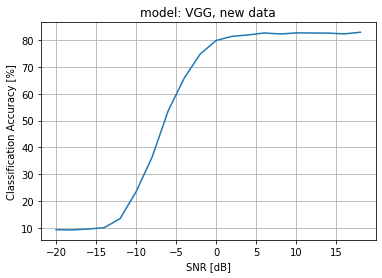

In [ ]:
#@title Perform Single model analysis
if loadTrainedModel is True:
  dataSet = "RML2016.10a_dict"
  if action == "Analyze model history":
    print('Analyzing model history')
    analyze_model_history()
  if action == "Show trained results":
    print('Showing trained results')
    show_trained_results(show_conf=False)


CNN2
RML2016.10a_dict
2016.04C.multisnr
Model #: 1/100, epoch #: 1
Model #: 11/100, epoch #: 11
Model #: 21/100, epoch #: 21
Model #: 31/100, epoch #: 31
Model #: 41/100, epoch #: 41
Model #: 51/100, epoch #: 51
Model #: 61/100, epoch #: 61
Model #: 71/100, epoch #: 71
Model #: 81/100, epoch #: 81
Model #: 91/100, epoch #: 91
CNN2_FFT
RML2016.10a_dict
Model #: 1/100, epoch #: 1
Model #: 11/100, epoch #: 11
Model #: 21/100, epoch #: 21
Model #: 31/100, epoch #: 31
Model #: 41/100, epoch #: 41
Model #: 51/100, epoch #: 51
Model #: 61/100, epoch #: 61
Model #: 71/100, epoch #: 71
Model #: 81/100, epoch #: 81
Model #: 91/100, epoch #: 91
2016.04C.multisnr
Model #: 1/100, epoch #: 1
Model #: 11/100, epoch #: 11
Model #: 21/100, epoch #: 21
Model #: 31/100, epoch #: 31
Model #: 41/100, epoch #: 41
Model #: 51/100, epoch #: 51
Model #: 61/100, epoch #: 61
Model #: 71/100, epoch #: 71
Model #: 81/100, epoch #: 81
Model #: 91/100, epoch #: 91
CNN2_ENSEMBLE
RML2016.10a_dict
Model #: 1/100, epoch

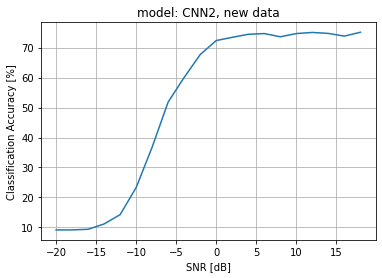

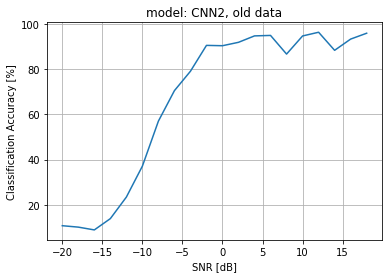

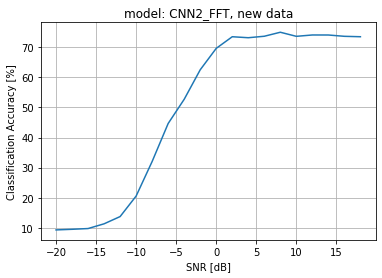

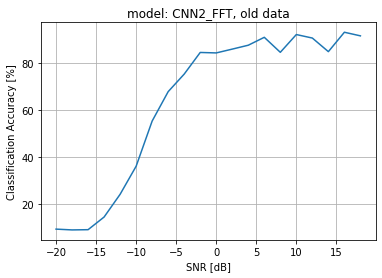

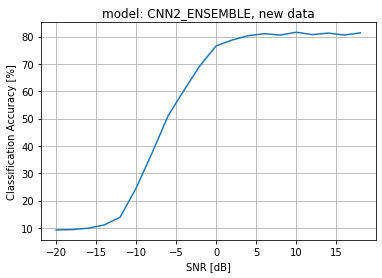

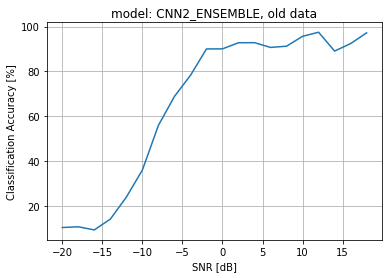

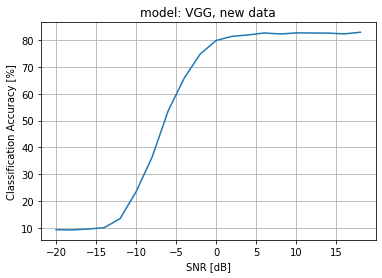

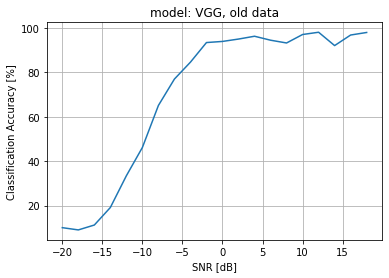

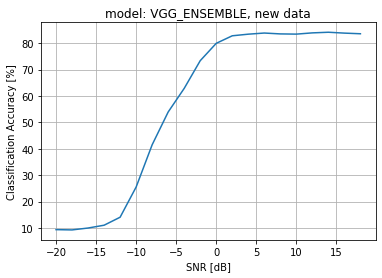

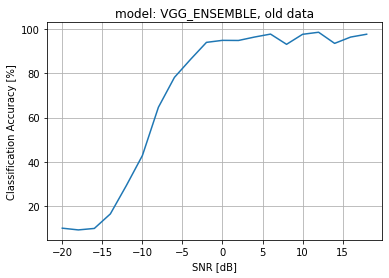

In [ ]:
#@title Analyze all saved models
loadTrainedModel = True

def analyze_all():
  global networkType, dataSet, net
  actions = ["Analyze model", "Show trained results"]
  networkTypes = ["CNN2", "CNN2_FFT", "CNN2_ENSEMBLE", "VGG", "VGG_ENSEMBLE"]
  dataSets = ["RML2016.10a_dict", "2016.04C.multisnr"]
  for networkType in networkTypes:
    print(networkType)
    for dataSet in dataSets:
      print(dataSet)
      load_dataset()
      partition_dataset()
      create_network()
      analyze_model_history()
      show_trained_results(show_conf=False)

analyze_all()


In [77]:
#@title Compare models helper functions

def comp_diff_data():
  global networkType
  networkTypes = ["CNN2", "CNN2_FFT", "CNN2_ENSEMBLE", "VGG", "VGG_ENSEMBLE"]
  for networkType in networkTypes:
    title = f'compare different data, model: {networkType}'
    old_data_path = f'{root}saved results/{networkType}, old data'
    new_data_path = f'{root}saved results/{networkType}, new data'
    fd = open(old_data_path, 'rb')
    acc_old = pickle.load(fd)[-1]
    fd.close()
    fd = open(new_data_path, 'rb')
    acc_new = pickle.load(fd)[-1]
    fd.close()

    plt.figure()
    plot_accuracy_graph([acc_old, acc_new], save_fig=True, save_path=f'{root}saved results/snr graphs/{title}', legend=['old data','new data'], title=title)


def comp_diff_nets():
  global dataSet, networkType

  dataSets = ["RML2016.10a_dict", "2016.04C.multisnr"]
  networkTypes = ["CNN2","CNN2_FFT", "CNN2_ENSEMBLE", "VGG", "VGG_ENSEMBLE"]

  for dataSet in dataSets:
    accs = []
    data_name = 'new data' if dataSet =="RML2016.10a_dict" else 'old data'
    title = f'compare different nets, data: {data_name}'
    for networkType in networkTypes:
      data_path = f'{root}saved results/{networkType}, {data_name}'
      fd = open(data_path, 'rb')
      accs.append(pickle.load(fd)[-1])
      fd.close()

    plt.figure()
    plot_accuracy_graph(accs, save_fig=True, save_path=f'{root}saved results/snr graphs/{title}', legend=networkTypes, title=title)
    get_snr_thresholds(data_name, accs)


def get_snr_thresholds(data_name, accs):
  print(f'\033[1;33m{data_name}\033[0m')
  networkTypes = ["CNN2","CNN2_FFT", "CNN2_ENSEMBLE", "VGG", "VGG_ENSEMBLE"]
  th = 50+100/22
  for netType, acc in zip(networkTypes, accs):
    detection_th = snrs[min(np.argwhere(np.array(list(acc.values())) > th))[0]]
    y2, y1 = (acc[detection_th], acc[detection_th - 2])
    slope = (y2 - y1) / 2
    x = (th - y1) / slope  # th = y1 + slope * x
    print(f'{netType} th: {x  + (detection_th - 2):.2f}dB')


new data
CNN2 th: -5.34dB
CNN2_FFT th: -3.63dB
CNN2_ENSEMBLE th: -5.26dB
VGG th: -5.85dB
VGG_ENSEMBLE th: -5.87dB
old data
CNN2 th: -8.25dB
CNN2_FFT th: -8.09dB
CNN2_ENSEMBLE th: -8.14dB
VGG th: -9.11dB
VGG_ENSEMBLE th: -8.93dB


<Figure size 432x288 with 0 Axes>

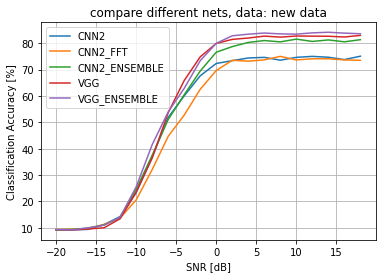

<Figure size 432x288 with 0 Axes>

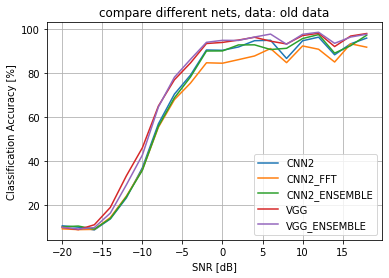

In [78]:
comp_diff_nets()

<Figure size 432x288 with 0 Axes>

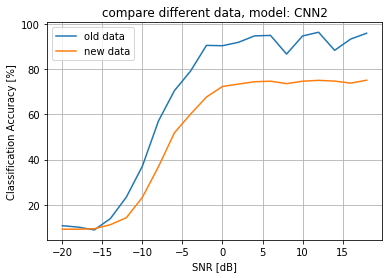

<Figure size 432x288 with 0 Axes>

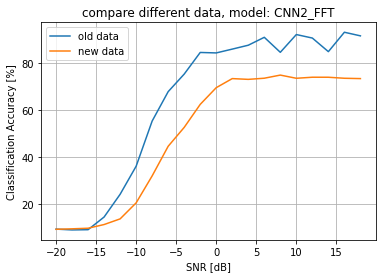

<Figure size 432x288 with 0 Axes>

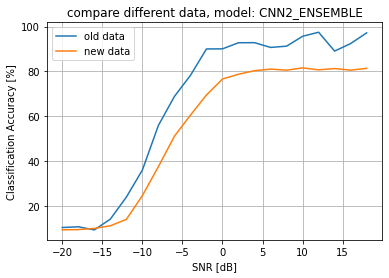

<Figure size 432x288 with 0 Axes>

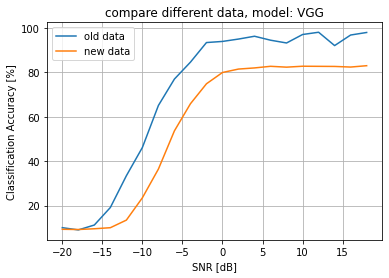

<Figure size 432x288 with 0 Axes>

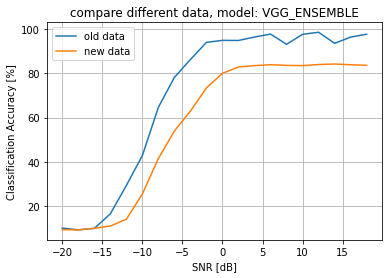

In [21]:
comp_diff_data()